# PSF CDP cube image to detector plane projection
In this notebook we illustrate the equivalence between the PSF CDP values in cube space and the 2D projected PSF values.

In [1]:
# load modules
import funcs
from distortionMaps import d2cMapping

import os
import numpy as np
from astropy.io import fits
from scipy.interpolate import RegularGridInterpolator
import matplotlib.pyplot as plt
%matplotlib notebook

import warnings
warnings.simplefilter('ignore')

In [2]:
# Define the paths to the data
workDir = '/Users/ioannisa/Desktop/python/miri_devel/'
cdpDir  = workDir+'cdp_data/'
d2cMapDir = workDir+'notebooks/distortionMaps/'

In [3]:
# Pick spectral band (side of the slope image) to be analyzed
band = '1A'

In [4]:
# load the MRS distortion maps, they are used extensively in a multitude of python functions relating to the analysis of MRS data
d2cMaps = d2cMapping(band,cdpDir+'CDP8/',fileversion = "8B.05.00") # here, d2c stands for detector to cube transformation, from x,y integer pixel coordinates, to alpha, beta (or RA and DEC), and wavelength coordinates

In [5]:
print('DISTORTION CDP filename: {}'.format(d2cMaps['cdp_filename']))

DISTORTION CDP filename: MIRI_FM_MIRIFUSHORT_12SHORT_DISTORTION_8B.05.00.fits


In [6]:
# load the MRS PSF CDP (3D cube image)
psffits = funcs.get_cdps(band,cdpDir)[3]
psf_cube_shape = psffits[1].data.shape

In [7]:
print('PSF CDP filename: {}'.format(os.path.basename(funcs.get_cdps(band,cdpDir,output='filepath')[2])))
print('Size of CDP PSF array: {}'.format(psf_cube_shape))

PSF CDP filename: MIRI_FM_MIRIFUSHORT_1SHORT_PSF_07.02.00.fits
Size of CDP PSF array: (218, 243, 243)


In [8]:
def evaluate_psf_cdp(psffits,d2cMaps,source_center=[0,0],norm=False,cdp_slice=None):
    # PSF CDP is provided as a spectral cube
    #>get values
    psf_values = psffits[1].data.transpose(2,1,0).copy() # flip data from Z,Y,X to X,Y,Z
    if norm:
        #>normalize values
        print('Normalizing PSF (divide by sum of all spaxel values)')
        for layer in range(psf_values.shape[2]):
            psf_values[:,:,layer] /= psf_values[:,:,layer].sum()
    if cdp_slice is not None:
        # use only a single layer of the PSF CDP cube
        print('Using single slice of PSF cube')
        for layer in range(psf_values.shape[2]):
            psf_values[:,:,layer] = psf_values[:,:,cdp_slice]

    #>get grid
    NAXIS1,NAXIS2,NAXIS3 = psf_values.shape

    alphastpix = psffits[1].header['CRPIX1'] # pixel nr
    alpha_step = psffits[1].header['CDELT1'] # arcsec/pix
    stalpha    = psffits[1].header['CRVAL1']-(alphastpix-1)*alpha_step # arcsec

    betastpix = psffits[1].header['CRPIX2'] # pixel nr
    beta_step = psffits[1].header['CDELT2'] # arcsec/pix
    stbeta    = psffits[1].header['CRVAL2']-(betastpix-1)*beta_step # arcsec

    stwavl = psffits[1].header['CRVAL3'] # microns
    wavl_step   = psffits[1].header['CDELT3'] # microns/pix

    alpha_slices = np.linspace(stalpha,stalpha+ (NAXIS1-1.5)*alpha_step,NAXIS1)
    beta_slices  = np.linspace(stbeta,stbeta+ (NAXIS2-1.5)*beta_step,NAXIS2)
    wvl_slices   = np.linspace(stwavl ,stwavl+NAXIS3*wavl_step,NAXIS3)

    #> center psf to source
    alpha_slices += source_center[0]
    beta_slices  += source_center[1]

    #> create interpolant based on regular grid
    interpolpsf = RegularGridInterpolator((alpha_slices,beta_slices,wvl_slices),psf_values)
    interpolpsf.fill_value=0.
    interpolpsf.bounds_error=False

    # evaluate psf at each pixel center and pixel corner
    alphaULMap = d2cMaps['alphaULMap']
    alphaURMap = d2cMaps['alphaURMap']
    alphaLLMap = d2cMaps['alphaLLMap']
    alphaLRMap = d2cMaps['alphaLRMap']
    alphaMap   = d2cMaps['alphaMap']

    betaULMap = d2cMaps['betaULMap']
    betaURMap = d2cMaps['betaURMap']
    betaLLMap = d2cMaps['betaLLMap']
    betaLRMap = d2cMaps['betaLRMap']
    betaMap   = d2cMaps['betaMap']

    lambdaULMap = d2cMaps['lambdaULMap']
    lambdaURMap = d2cMaps['lambdaURMap']
    lambdaLLMap = d2cMaps['lambdaLLMap']
    lambdaLRMap = d2cMaps['lambdaLRMap']
    lambdaMap = d2cMaps['lambdaMap']

    #> interpolate psf to science image pixel centers and corners
    #-- assume no significant change in wavelength over one pixel size
    psfUL  = interpolpsf((alphaULMap,betaULMap,lambdaULMap))
    psfUR  = interpolpsf((alphaURMap,betaURMap,lambdaURMap))
    psfLL  = interpolpsf((alphaLLMap,betaLLMap,lambdaLLMap))
    psfLR  = interpolpsf((alphaLRMap,betaLRMap,lambdaLRMap))
    psfCEN = interpolpsf((alphaMap,betaMap,lambdaMap))

    #> evaluate psf as a weighted average
    w = np.array([0.125,0.125,0.125,0.125,0.5]) # WARNING: ARBITRARY!
    sumweights = w.sum()

    psf = (w[0]*psfUL+w[1]*psfUR+w[2]*psfLL+w[3]*psfLR+w[4]*psfCEN)/sumweights
    
    print('DONE')
    return psf

In [9]:
# define centroid
source_alpha_center = 0.
source_beta_center  = 0.

# project PSF from spectral cube to detector plane
psf_img = evaluate_psf_cdp(psffits,d2cMaps,source_center=[source_alpha_center,source_beta_center],norm=True,cdp_slice=None)

# use the following examples for testing
psf_img2 = evaluate_psf_cdp(psffits,d2cMaps,source_center=[source_alpha_center,source_beta_center],norm=True,cdp_slice=psf_cube_shape[0]/2)

Normalizing PSF (divide by sum of all spaxel values)
DONE
Normalizing PSF (divide by sum of all spaxel values)
Using single slice of PSF cube
DONE


<IPython.core.display.Javascript object>


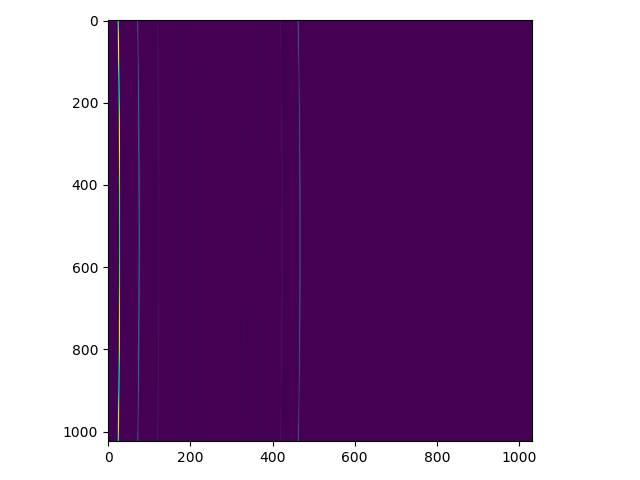

In [10]:
# plot result
plt.figure()
plt.imshow(psf_img)
plt.tight_layout()

<IPython.core.display.Javascript object>


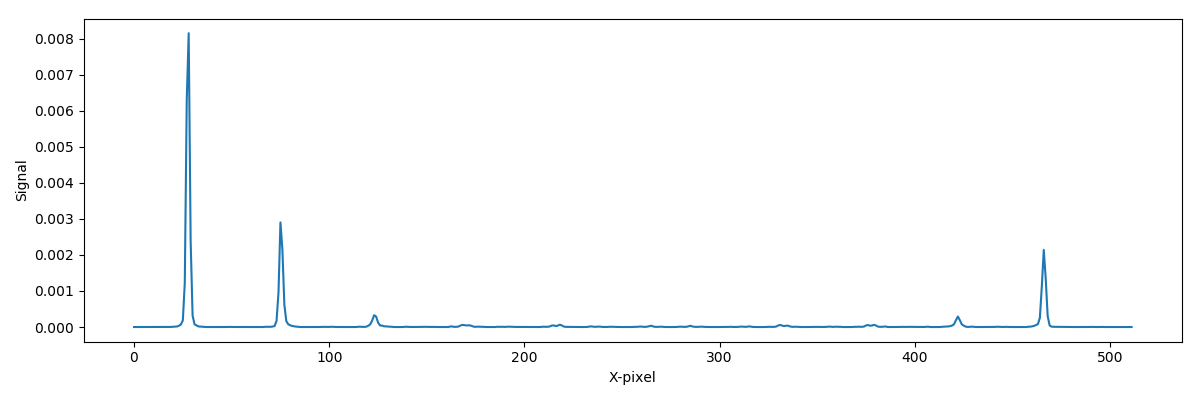

In [14]:
# plot detector row
plt.figure(figsize=(12,4))
plt.plot(psf_img[512,:512])
plt.xlabel('X-pixel')
plt.ylabel('Signal')
plt.tight_layout()

<IPython.core.display.Javascript object>


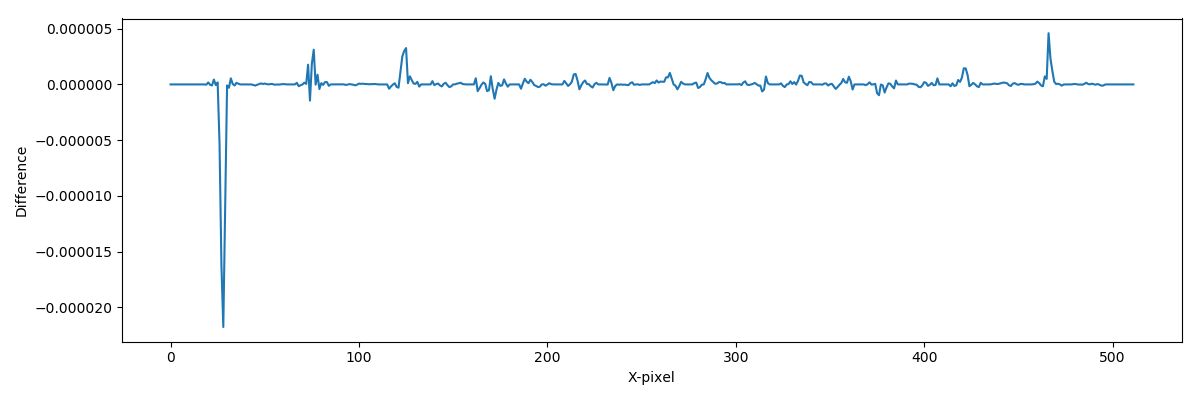

In [15]:
# plot comparison
plt.figure(figsize=(12,4))
plt.plot(psf_img[512,:512]-psf_img2[512,:512])
plt.xlabel('X-pixel')
plt.ylabel('Difference')
plt.tight_layout()